## Regression Assignment
### Gowlapalli Rohit 2021101113

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import bartlett
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

In [87]:
df = pd.read_csv("housing.csv")
counts = df['ocean_proximity'].value_counts()

#### We can see that ocean_proximity is having string variables. Lets convert it to numericals before we perform the correlation analysis

In [88]:
# cleaning the data by removing the nan values and changing data to numerical variables
df['ocean_proximity'] = df['ocean_proximity'].map({'<1H OCEAN':0, 'INLAND':1, 'NEAR OCEAN':2, 'NEAR BAY':3, 'ISLAND':4})
df = df.dropna()

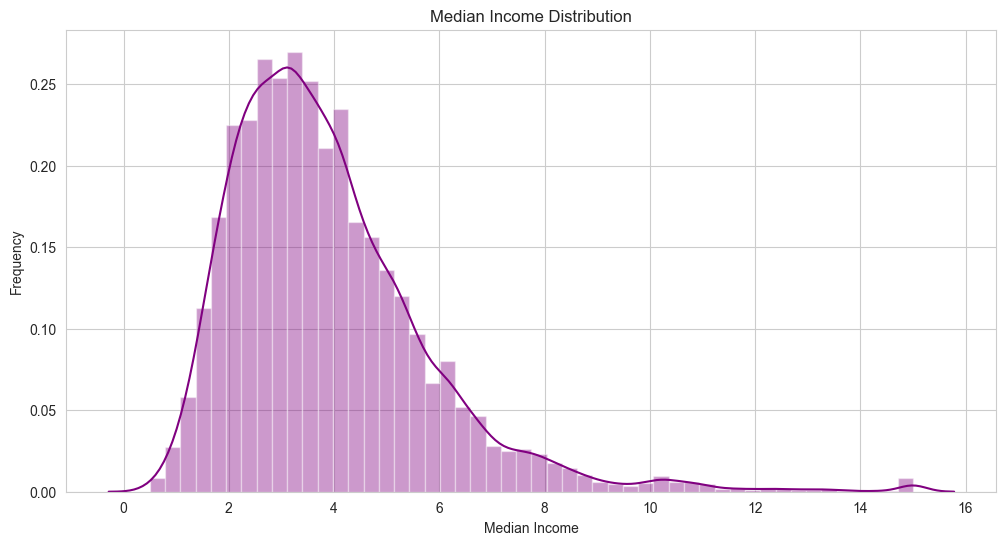

In [89]:
df_1 = df['median_income']
df_1 = np.array(pd.DataFrame(df_1, columns=['median_income'])).reshape(-1, 1)
y = df['median_house_value']
df_2 = df.copy()
df_2 = df_2.drop('median_house_value', axis=1)

# plot a histogram for median income
plt.figure(figsize=(12, 6))
sns.distplot(df['median_income'], bins=50, color='purple')
plt.title('Median Income Distribution')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.show()

<Axes: >

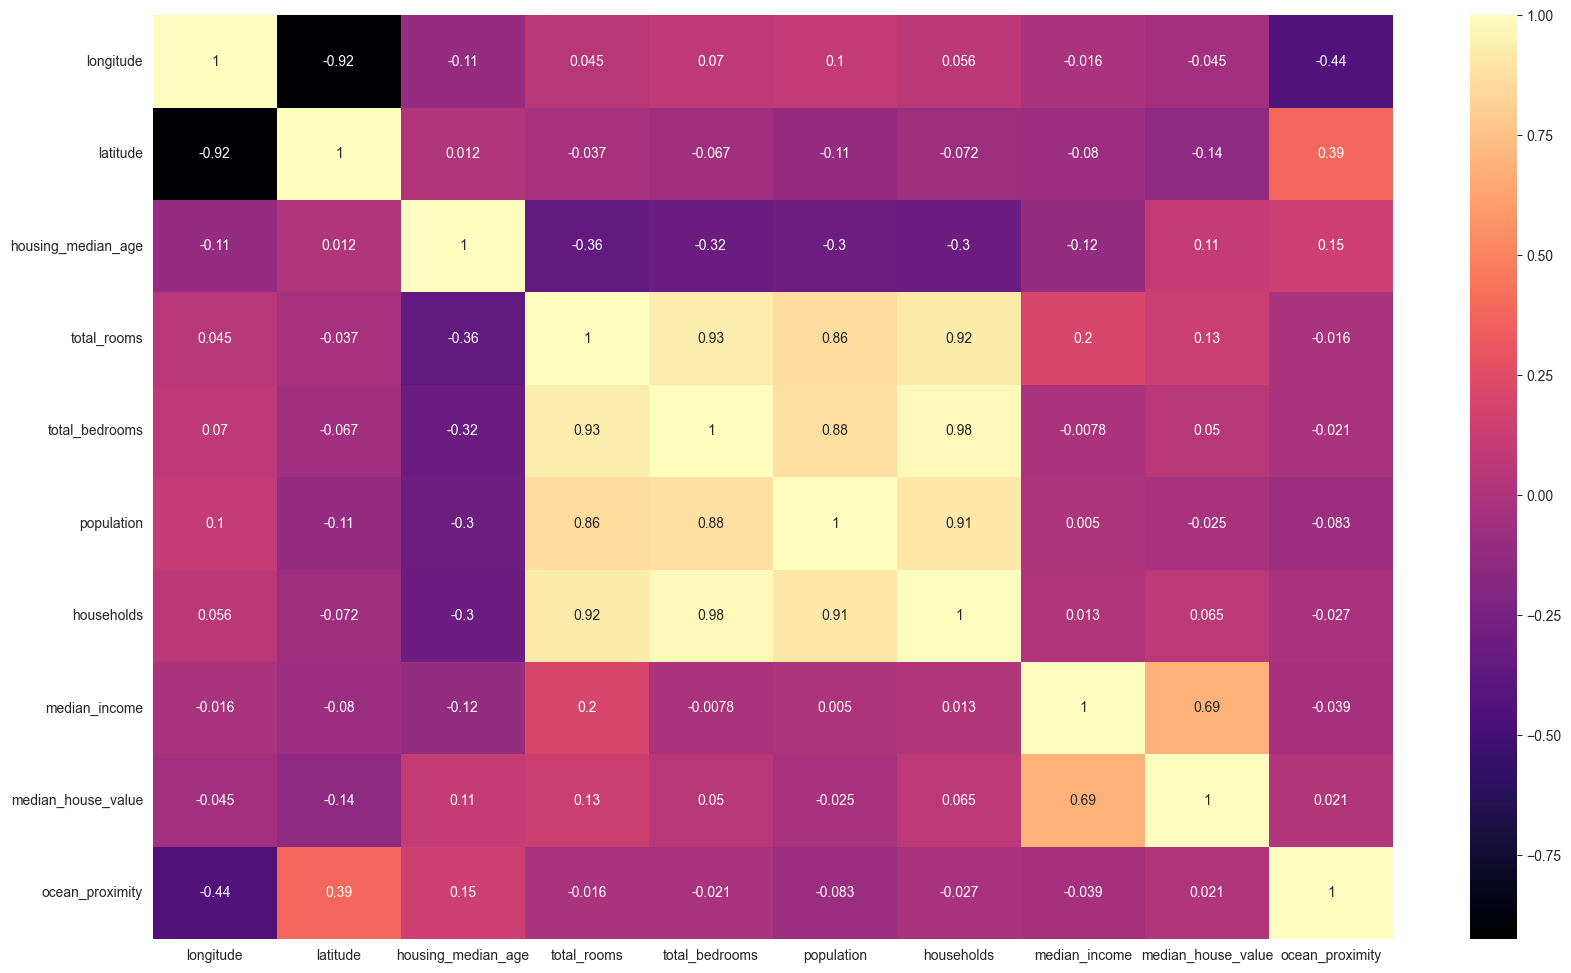

In [90]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cmap='magma')

#### We can clearly see some of the variables are highly correlated, now lets perform a correlation test to confirm the collinearity before building the model

In [91]:
def correlation_test(data1, data2, alternative):
    corr, p_value = pearsonr(data1, data2)
    print("Correlation coefficient:", corr)
    print("p-value:", p_value)
    print("Alternative hypothesis:", alternative)
    if alternative == "greater":
        if p_value/2 < 0.05:
            print("Reject the null hypothesis: There is a positive correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no positive correlation between the two variables")
    elif alternative == "less":
        if p_value/2 < 0.05:
            print("Reject the null hypothesis: There is a negative correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no negative correlation between the two variables")
    else:
        if p_value < 0.05:
            print("Reject the null hypothesis: There is a correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no correlation between the two variables")

print("Correlation test for total_bedrooms and total_rooms:")
correlation_test(df['total_bedrooms'], df['total_rooms'], alternative="greater")
print("\nCorrelation test for households and population:")
correlation_test(df['households'], df['population'], alternative="greater")
print("\nCorrelation test for longitude and latitude:")
correlation_test(df['longitude'], df['latitude'], alternative="less")

Correlation test for total_bedrooms and total_rooms:
Correlation coefficient: 0.930377047611133
p-value: 0.0
Alternative hypothesis: greater
Reject the null hypothesis: There is a positive correlation between the two variables

Correlation test for households and population:
Correlation coefficient: 0.9071823610456953
p-value: 0.0
Alternative hypothesis: greater
Reject the null hypothesis: There is a positive correlation between the two variables

Correlation test for longitude and latitude:
Correlation coefficient: -0.9246131238737124
p-value: 0.0
Alternative hypothesis: less
Reject the null hypothesis: There is a negative correlation between the two variables


##### Based on the correlation tests conducted earlier, it's evident that whenever the p-value falls below 0.05, indicating a significant correlation, utilizing just one of the variables from the correlated pair is adequate for model construction.

##### We constructed three linear regression models by selecting only one variable from each highly correlated pair, effectively reducing the dimensions by three in each model. In the third model, we employed only two variables with notably high absolute correlation values. Notably, in all cases, the p-value was below 0.05, indicating a strong fit of the model to the data.

### Method 1 : Model 1 - Linear Regression

In [92]:
f1 = 'median_house_value ~ longitude + housing_median_age + total_rooms + households + median_income + ocean_proximity'
model = sm.formula.ols(formula=f1, data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     3968.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:31:28   Log-Likelihood:            -2.5926e+05
No. Observations:               20432   AIC:                         5.185e+05
Df Residuals:                   20425   BIC:                         5.186e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.134e+05   3.63

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
features = ['longitude', 'housing_median_age', 'total_rooms', 'households', 'median_income', 'ocean_proximity']
X = df[features]
vif_data_f1 = pd.DataFrame()
vif_data_f1["Feature"] = X.columns
vif_data_f1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data_f1)

              Feature        VIF
0           longitude  17.077745
1  housing_median_age   7.320093
2         total_rooms  21.136321
3          households  21.646955
4       median_income   6.654595
5     ocean_proximity   1.889437



##### To address collinearity, we utilized the Variance Inflation Factor (VIF) to detect multicollinearity. A VIF value above 5 suggests significant multicollinearity within the model, indicating the need for further adjustments.

##### A VIF exceeding 5 presents a potential issue. Therefore, in our scenario, we could address multicollinearity by eliminating either 'total_rooms' or 'households', as they exhibit high correlation with each other.

In [94]:
f1_modified = 'median_house_value ~ longitude + housing_median_age + households + median_income + ocean_proximity'
model_modified = sm.formula.ols(formula=f1_modified, data=df)
result_modified = model_modified.fit()
print(result_modified.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     4500.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:31:28   Log-Likelihood:            -2.5957e+05
No. Observations:               20432   AIC:                         5.192e+05
Df Residuals:                   20426   BIC:                         5.192e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.094e+05   3.69

In [95]:
features_modified = ['longitude', 'housing_median_age', 'households', 'median_income', 'ocean_proximity']
X_modified = df[features_modified]
vif_data_f1_modified = pd.DataFrame()
vif_data_f1_modified["Feature"] = X_modified.columns
vif_data_f1_modified["VIF"] = [variance_inflation_factor(X_modified.values, i) for i in range(len(X_modified.columns))]
print(vif_data_f1_modified)

              Feature        VIF
0           longitude  16.775420
1  housing_median_age   7.043675
2          households   2.972707
3       median_income   5.242511
4     ocean_proximity   1.877785


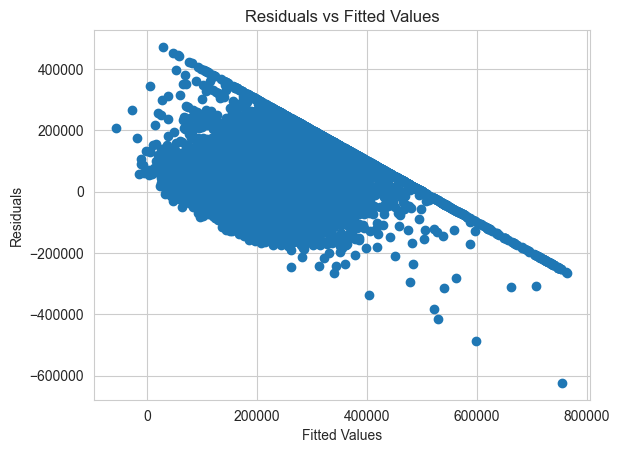

In [96]:
my_resid = result.resid
my_fitted = result.fittedvalues

# Create scatter plot
plt.scatter(my_fitted, my_resid)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [97]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)

Lagrange multiplier statistic: 524.671115578385
p-value for Lagrange multiplier test: 4.065464026424511e-110
F-statistic: 89.71911465291723
p-value for F-statistic: 1.4456207494871716e-111


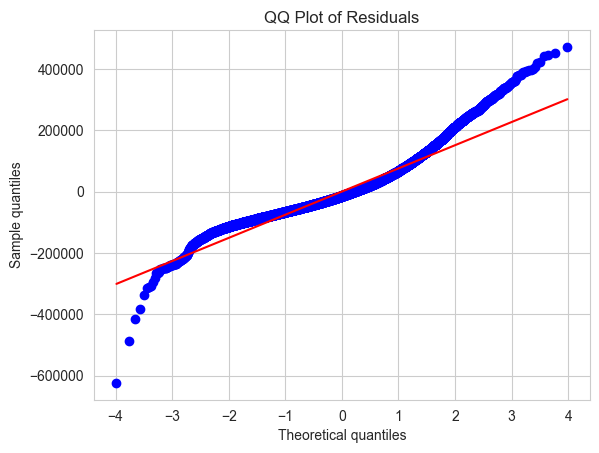

In [98]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

### Method 2 : Model 2 - Linear Regression

In [99]:
f2 = 'median_house_value ~ latitude + housing_median_age + total_bedrooms + population + median_income + ocean_proximity'
model = sm.formula.ols(formula=f2, data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4331.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:31:29   Log-Likelihood:            -2.5877e+05
No. Observations:               20432   AIC:                         5.176e+05
Df Residuals:                   20425   BIC:                         5.176e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.898e+05   1.01

In [100]:
features_r2 = ['latitude', 'housing_median_age', 'total_bedrooms', 'population', 'median_income', 'ocean_proximity']
X_r2 = df[features_r2]
vif_data_f2 = pd.DataFrame()
vif_data_f2["Feature"] = X_r2.columns
vif_data_f2["VIF"] = [variance_inflation_factor(X_r2.values, i) for i in range(len(X_r2.columns))]
print(vif_data_f2)

              Feature        VIF
0            latitude  16.080084
1  housing_median_age   6.769862
2      total_bedrooms  11.855788
3          population  11.424839
4       median_income   5.053573
5     ocean_proximity   1.958505


In [101]:
# remove total_bedrooms and latitude from the model
f2_modified = 'median_house_value ~ housing_median_age + population + median_income + ocean_proximity'
model_modified = sm.formula.ols(formula=f2_modified, data=df)
result_modified = model_modified.fit()
print(result_modified.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     5336.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:31:29   Log-Likelihood:            -2.5985e+05
No. Observations:               20432   AIC:                         5.197e+05
Df Residuals:                   20427   BIC:                         5.197e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.925e+04   2293

In [102]:
features_modified_r2 = ['housing_median_age', 'population', 'median_income', 'ocean_proximity']
X_modified_r2 = df[features_modified_r2]
vif_data_f2_modified = pd.DataFrame()
vif_data_f2_modified["Feature"] = X_modified_r2.columns
vif_data_f2_modified["VIF"] = [variance_inflation_factor(X_modified_r2.values, i) for i in range(len(X_modified_r2.columns))]
print(vif_data_f2_modified)

              Feature       VIF
0  housing_median_age  3.343390
1          population  2.060318
2       median_income  3.398675
3     ocean_proximity  1.803963


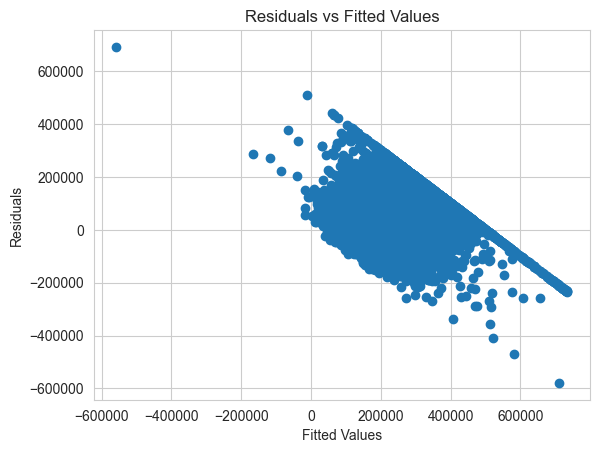

In [103]:
my_resid = result.resid
my_fitted = result.fittedvalues
plt.scatter(my_fitted, my_resid)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [104]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)

Lagrange multiplier statistic: 530.6990859553763
p-value for Lagrange multiplier test: 2.0419154123841378e-111
F-statistic: 90.77738918890613
p-value for F-statistic: 6.710276783079889e-113


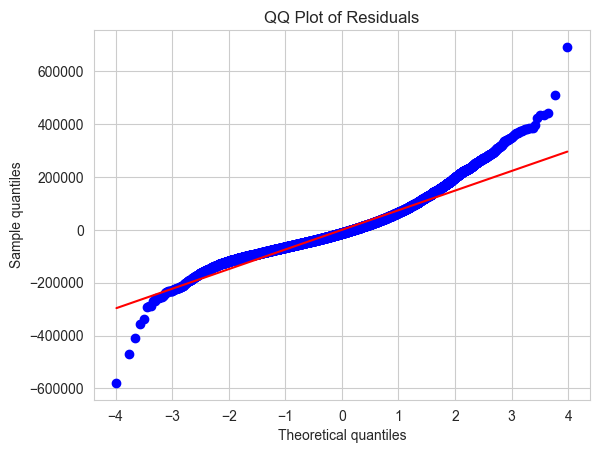

In [105]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

### Method 3 : Model 3 - Linear Regression

In [106]:
f3 = 'median_house_value ~ median_income + ocean_proximity'
model = sm.formula.ols(formula=f3, data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     9284.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:31:30   Log-Likelihood:            -2.6055e+05
No. Observations:               20432   AIC:                         5.211e+05
Df Residuals:                   20429   BIC:                         5.211e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.944e+04   1446.897     

In [107]:
features_r3 = ['median_income', 'ocean_proximity']
X_r3 = df[features_r3]
vif_data_r3 = pd.DataFrame()
vif_data_r3["Feature"] = X_r3.columns
vif_data_r3["VIF"] = [variance_inflation_factor(X_r3.values, i) for i in range(len(X_r3.columns))]
print(vif_data_r3)

           Feature       VIF
0    median_income  1.533248
1  ocean_proximity  1.533248


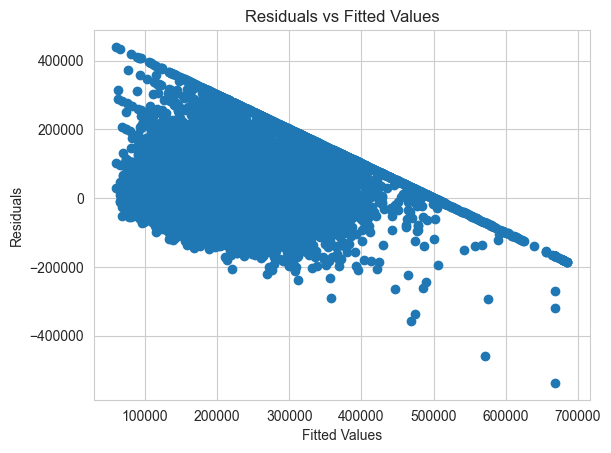

In [108]:
my_resid = result.resid
my_fitted = result.fittedvalues

# Create scatter plot
plt.scatter(my_fitted, my_resid)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [109]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)

Lagrange multiplier statistic: 226.94422753778065
p-value for Lagrange multiplier test: 5.244295323706217e-50
F-statistic: 114.72979032030526
p-value for F-statistic: 2.826404299850481e-50


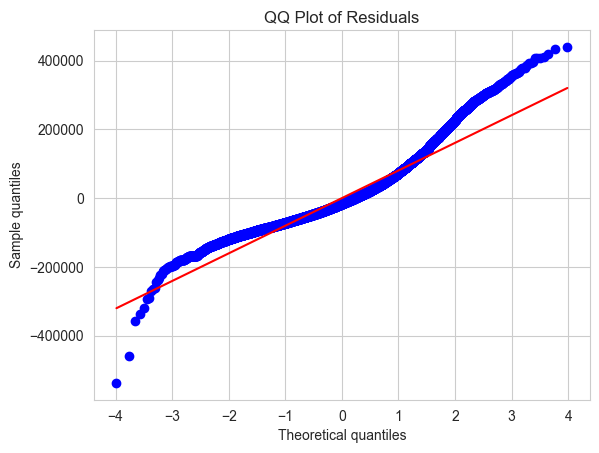

In [110]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

### Method - 4 : Simple Linear Regression

Text(0.5, 1.0, 'Median Income vs median_house_value - Model 1')

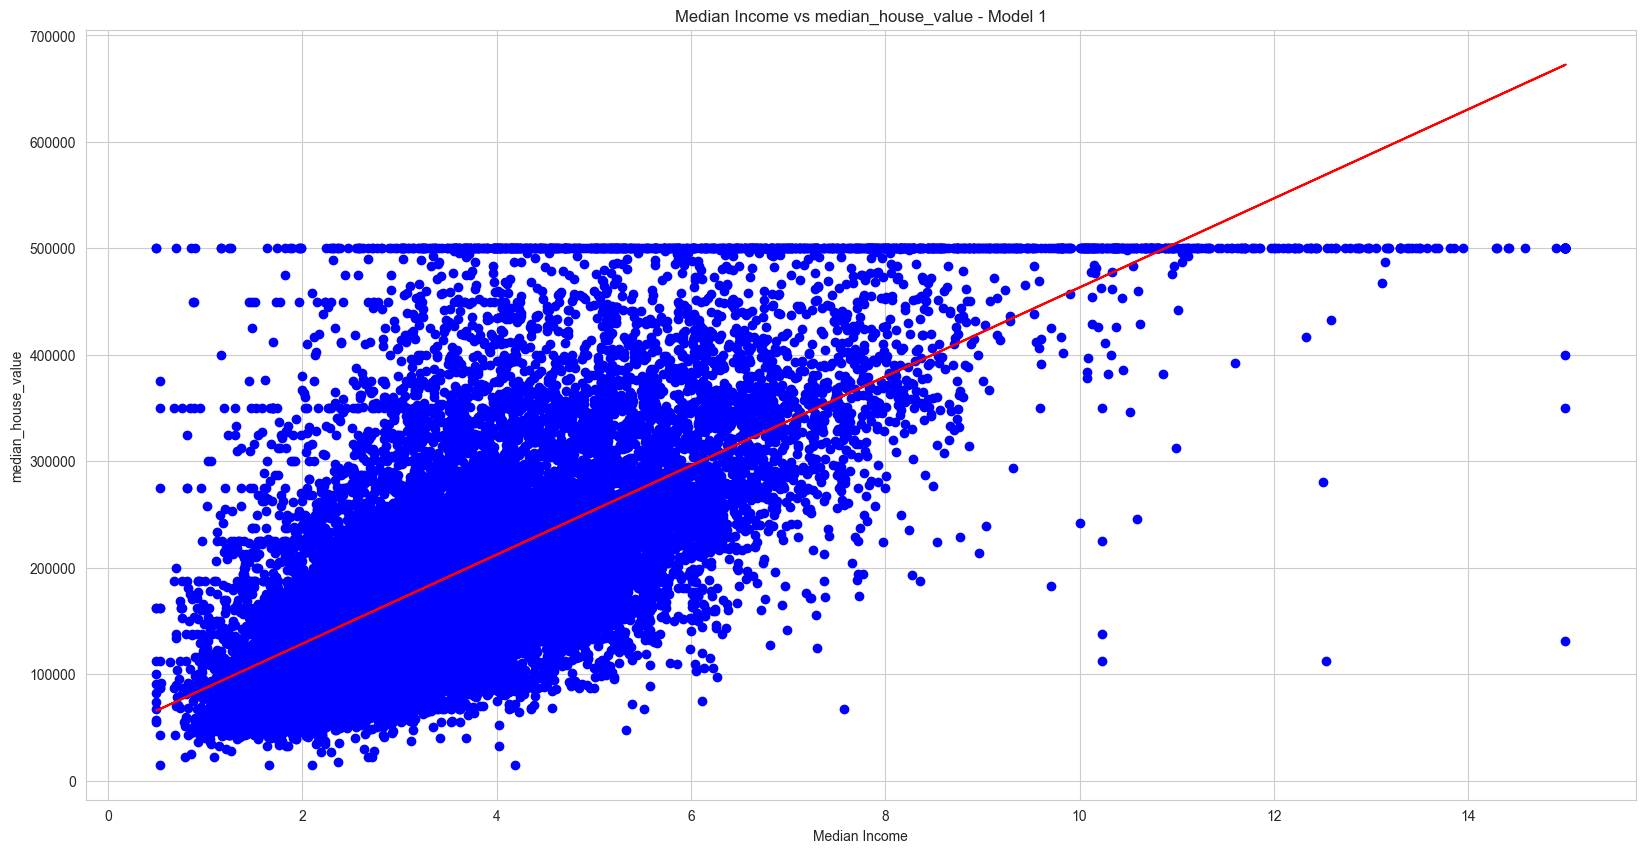

In [111]:
reg = LinearRegression()
reg.fit(df_1, y)
y_pred = reg.predict(df_1)
plt.figure(figsize=(20, 10))
plt.scatter(df_1, y, color='blue')
plt.plot(df_1, y_pred, color='red')
plt.xlabel('Median Income')
plt.ylabel('median_house_value')
plt.title('Median Income vs median_house_value - Model 1')

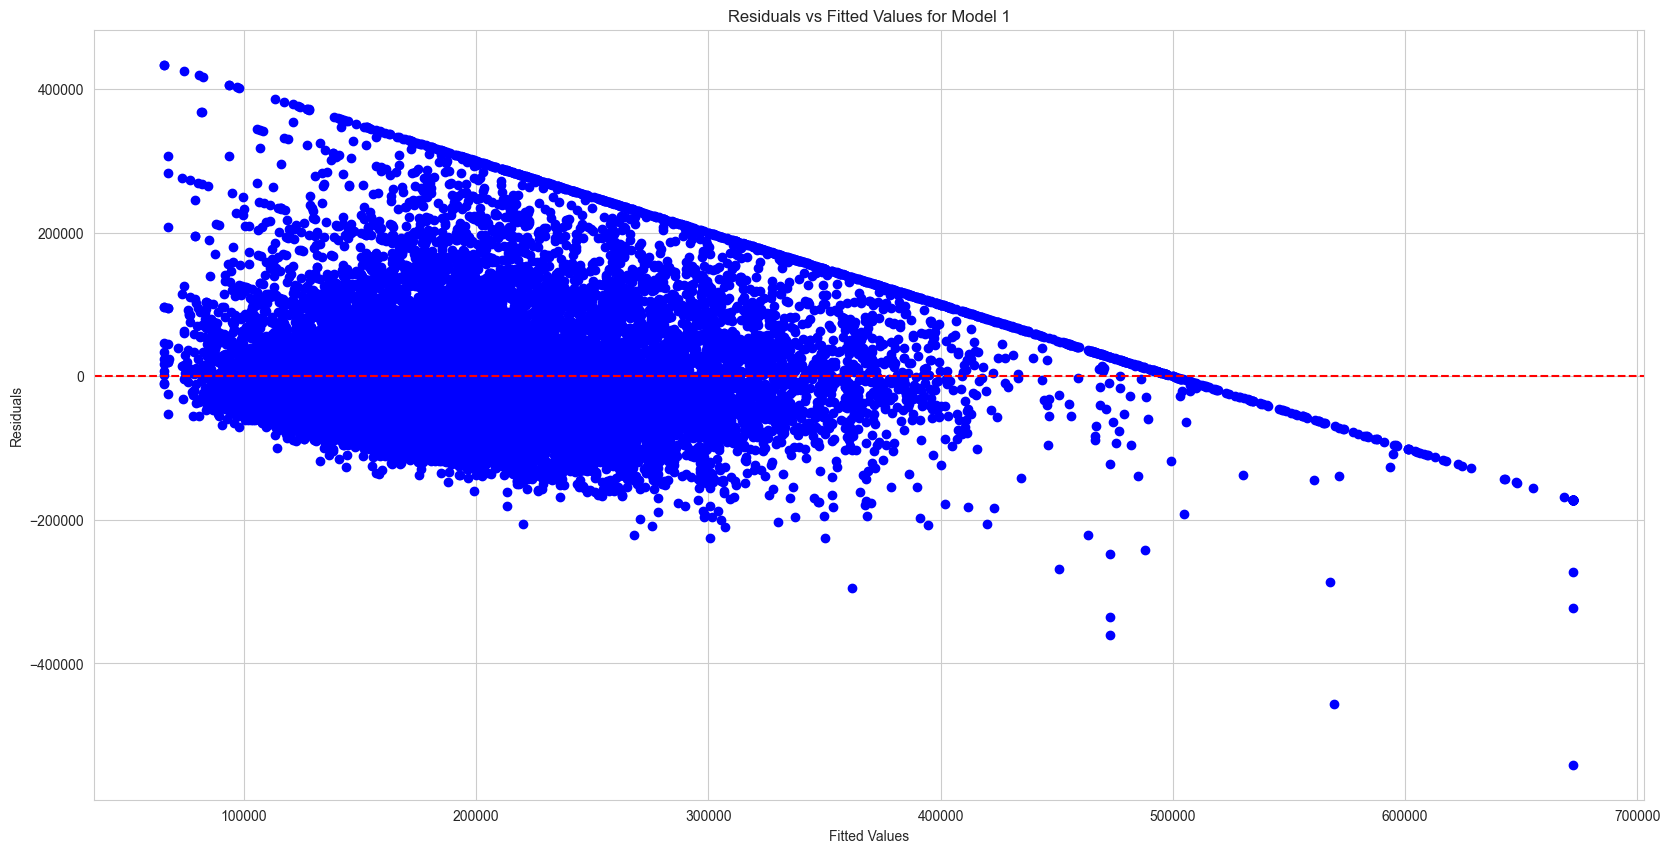

In [112]:
residuals = y - y_pred
plt.figure(figsize=(20, 10))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for Model 1')
plt.show()

### Method - 5: Multiple Linear Regression

The mean squared error is:  4836361368.241866


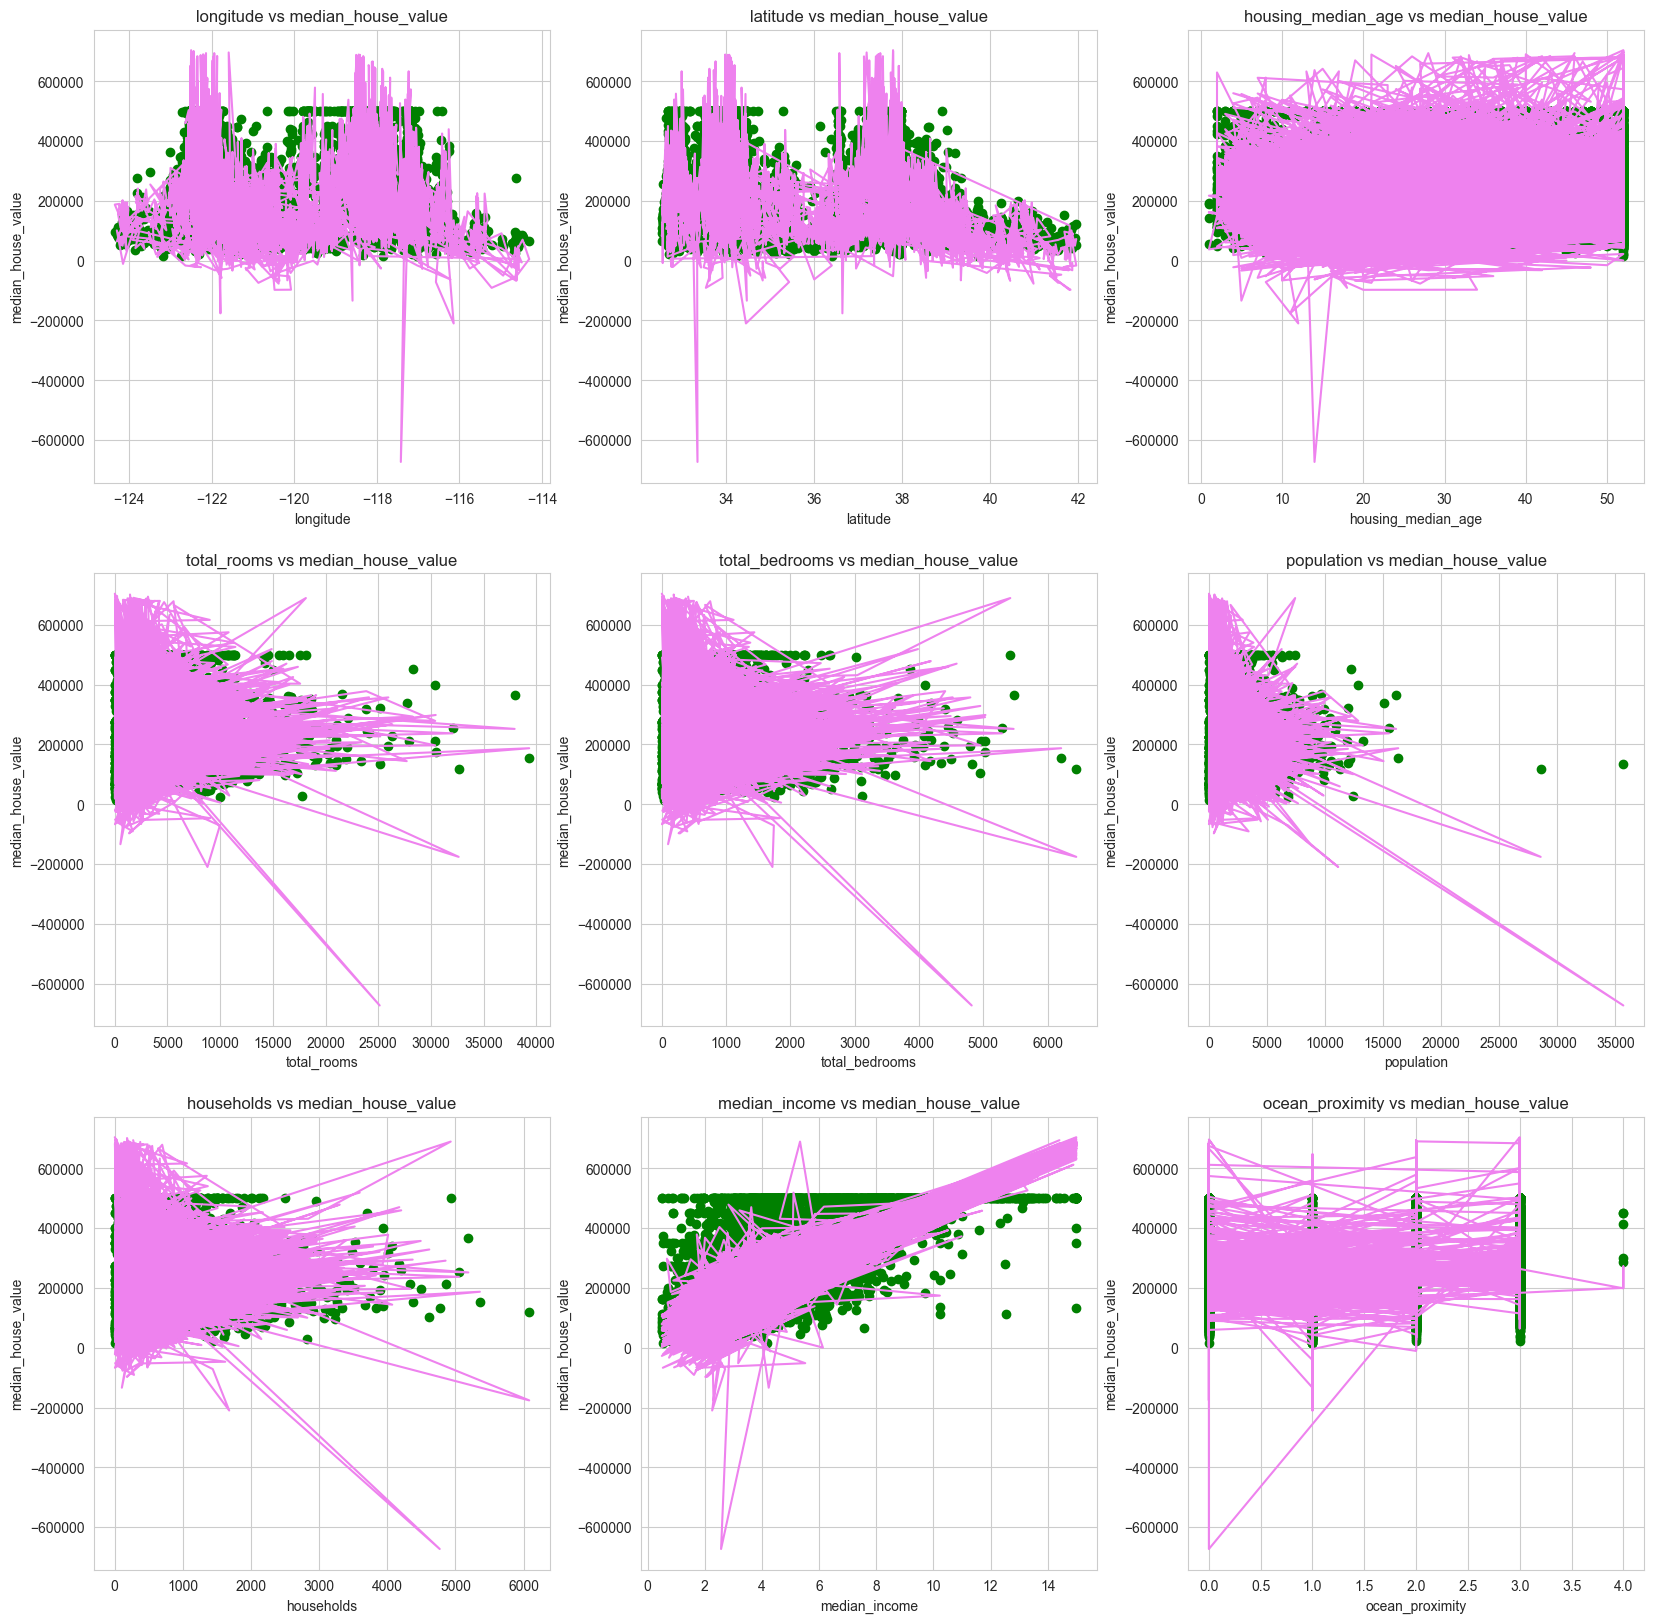

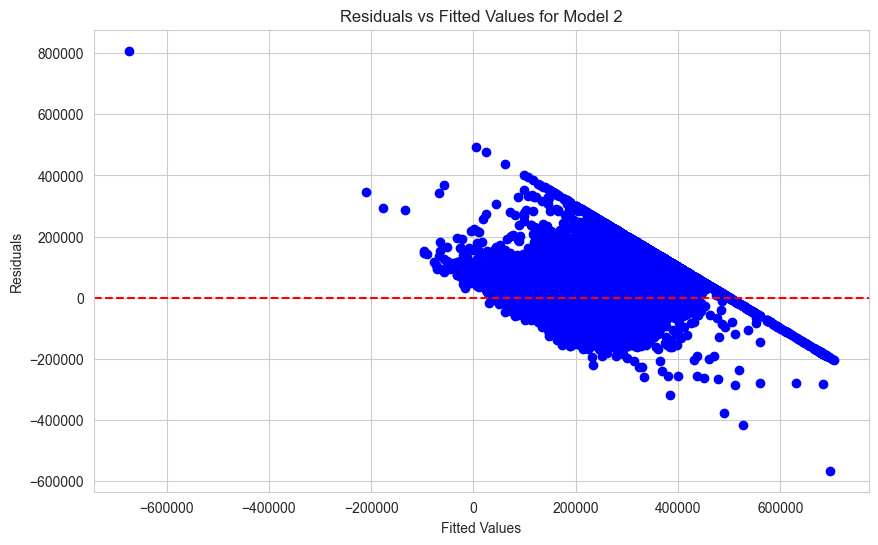

In [113]:
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

mse = mean_squared_error(y_pred, y)
print("The mean squared error is: ", mse)

plt.figure(figsize=(20, 20))
for i in range(0, len(df_2.columns)):
    plt.subplot(3, 3, i+1)
    plt.scatter(df_2.iloc[:, i], y, color='green')
    plt.plot(df_2.iloc[:, i], y_pred, color='violet')
    plt.xlabel(df_2.columns[i])
    plt.ylabel('median_house_value')
    plt.title(df_2.columns[i]+' vs median_house_value')

residuals = y - y_pred
mse = mean_squared_error(y_pred, y)

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for Model 2')
plt.show()

In [114]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = df_2.columns
vif_data["VIF"] = [variance_inflation_factor(df_2.values, i) for i in range(len(df_2.columns))]

In [115]:
X = df_2
for i in range(0,5):
    max_vif_index = vif_data['VIF'].idxmax()
    X = X.drop(vif_data['feature'][max_vif_index], axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
df_vif = X
print("The final values are as follows: ")
print(vif_data)

The final values are as follows: 
              feature       VIF
0  housing_median_age  3.343390
1          population  2.060318
2       median_income  3.398675
3     ocean_proximity  1.803963


### VIF is used to check multicollinearity, so if VIF is above 5 then it indicates high multicollinearity

#### Overall, the VIF values indicate that while there is some degree of collinearity among the predictors, it is not severe enough to cause significant multicollinearity issues.

#### The variables "population" and "ocean_proximity" have relatively low VIF values, suggesting they are less correlated with other predictors in the model.

#### The variables "housing_median_age" and "median_income" have slightly higher VIF values, indicating a moderate degree of collinearity, but it's still within an acceptable range.

#### These results suggest that the selected predictors may be suitable for inclusion in a linear regression model without significant multicollinearity concerns. However, it's always important to consider the context of the analysis and interpret the results accordingly.

#### We get the conclusion that there is no constant variance despite the fact that constant variance is supposed to be necessary for regression because of the uneven distribution of the residuals. Consequently, heteroscedasticity exists. 

In [116]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
X_with_const = sm.add_constant(X)
ncv_test_result = het_breuschpagan(residuals, X_with_const,robust='hc1')
p_value_ncv_test = ncv_test_result[1]
print("The p-value of the Breusch-Pagan test with sandwich estimator is: ", p_value_ncv_test)

The p-value of the Breusch-Pagan test with sandwich estimator is:  2.0758043938158592e-71


Since the p-value for each test is less than 0.05, we may say that the data are heteroscedastic.

#### Since the p-value is much smaller than any reasonable significance level (e.g., 0.05), we reject the null hypothesis of homoscedasticity. Therefore, we conclude that there is strong evidence of heteroscedasticity in the residuals of the linear regression model.

#### Implications: Heteroscedasticity violates one of the assumptions of linear regression, which is that the residuals should have constant variance. In the presence of heteroscedasticity, the standard errors of the estimated coefficients may be biased, leading to incorrect inferences about the statistical significance of the regression coefficients.

QQ-plot for Model 1: 


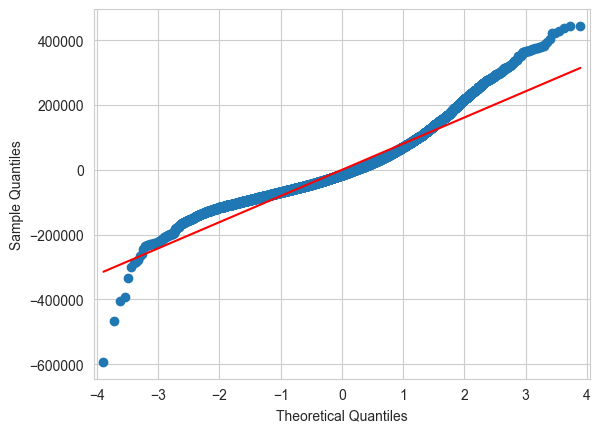

QQ plot for Model 2: 


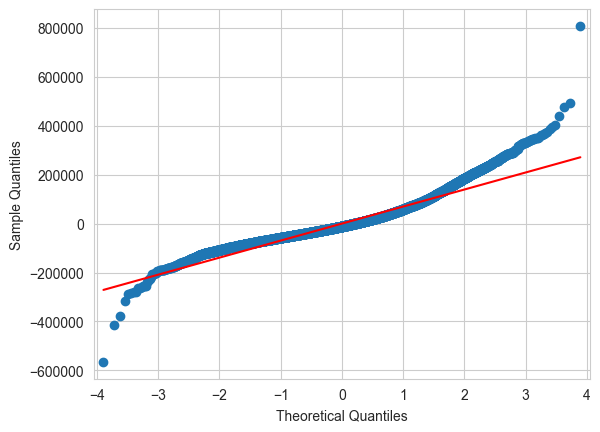

In [117]:
print("QQ-plot for Model 1: ")
X = df_vif
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred
sm.qqplot(residuals, line='s') 
plt.show()

print("QQ plot for Model 2: ")
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred
sm.qqplot(residuals, line='s')
plt.show()


### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

As indicated by Q-Q plot, the residuals are not normally distributed

In [118]:
import statsmodels.api as sm

X = df_1
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred

X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred

# calculate the AIC for the model with only median income (most correlated)
X = df_1
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("AIC for the model with only median income: ", model.aic)

# calculate the AIC for the model with all the features
X = df_2
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("AIC for the model with all the features: ", model.aic)

AIC for the model with only median income:  521196.99479050474
AIC for the model with all the features:  513625.4271596733


### The model with all features has a lower AIC and hence performs better 

In [119]:
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     3983.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:31:34   Log-Likelihood:            -2.5680e+05
No. Observations:               20432   AIC:                         5.136e+05
Df Residuals:                   20422   BIC:                         5.137e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.633e+06   6.51

#### R-square value of 0.637 says that the model explains 61% of the variation in the response variable and also higher t-values whose absolute value is greater than 2 imply that the estimate of regression coefficient is significant. Higher the absolute t-value higher the significance that variables are related